# Library

In [2]:
!pip install xgboost
!pip install lightgbm[scikit-learn]
!pip install catboost
!pip install bayesian-optimization

In [ ]:
# 설치 시 문제가 발생하면 아래 코드 먼저 실행
!pip install --upgrade pip setuptools wheel

In [ ]:
# apple
https://github.com/microsoft/LightGBM/blob/master/docs/Installation-Guide.rst#apple-clang

In [163]:
import pandas as pd
import numpy as np
import scipy as sp

import xgboost
import lightgbm
import catboost

from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization  # bayesian-optimization

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

# Gradient Boosting


![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99A9FC375C46C0201B)

모델 1을 통해 y를 예측하고 남은 잔차(residual)을 모델 2를 통해 예측. <br>
모델 2를 통해 y를 예측하고 남은 잔차(resiudal)을 모델 3을 통해 예측. <br>
이렇게 만들어진 모델 1 + 모델 2 + ... 을 통해 y를 에측하여 개별 분류기보다 좋은 모델 구축. <br>
위의 과정을 반복하면 잔차는 계속 줄어들어 training set을 잘 설명하는 모델 구축 가능. <br>
하지만 이 경우 잔차는 줄일 수 있을지라도 과적합이 쉽게 발생할 수 있음. <br>
현재 사용되는 boosting 계열의 알고리즘은 penalizaing, regularization 등의 테크닉을 활용하여 이러한 과적합 방지. <br>

<br>

<font style="font-size:20px"> Negative Gradient </font> <p>

residual은 loss function을 squared error로 하였을 시 negative gradient로 표현

$$ L(y_i, f(x_i)) = \frac{1}{2}(y_i - f(x_i))^2 $$
$$ \frac{\partial(y_i, f(x_i))}{\partial f(x_i)} = \frac{\partial [ \frac{1}{2}(y_i - f(x_i))^2 
]}{\partial f(x_i)} = f(x_i) - y_i = -(y_i - f(x_i))$$ 
$$ \text{residual: } y_i - f(x_i) $$

위의 식에서 알 수 있듯이 다음 모델 구축 시 negative gradient를 이용하기에 gradient boosting이라고 부름. <br>
분류 문제의 경우 squared error를 이용할 수 없으나 negative gradient를 이용해 새로운 model을 fitting하고 이를 합산하여 최종 모델 구축

negative gradient는 pseudo-residual이라고도 불리며, 이는 데이터 포인트에서 loss를 줄이기 위해 f(x)가 가려고 하는 방향이라고 해석할 수 있음 <br>
f(x)가 가려고 하는 방향에 새로운 모델을 fitting하여 이전 모델과 결합하여 loss를 줄이도록 업데이트 하는 것이 핵심 아이디어 <br>

<font style="font-size:20px"> Leaf-wise Level-wise </font> <p>

![](https://www.researchgate.net/publication/353155099/figure/fig2/AS:1044071766310913@1625937515739/Level-wise-vs-leaf-wise-tree-growth.png)

- leaf-wise: 불균형트리
    - LightGBM
- level-wise: 균형트리
    - XGBoost
    - CatBoost

## XGBoost

Paper: [Click](https://arxiv.org/pdf/1603.02754) <br>
Documentation: https://xgboost.readthedocs.io/en/stable/python/index.html <br>

### 핵심 로직

<font style="font-size:20px"> Parallelization and GPU </font> <p>

<img src="https://blog-ko.superb-ai.com/content/images/2023/05/data-src-image-8ec4acab-254c-45c1-82ba-6027a7479ab0.png" height="200"/>

- 분산 컴퓨팅으로 일부 로직에 대한 병렬화
- GPU지원으로 빠른 학습 가능

<br>

![](https://blog-ko.superb-ai.com/content/images/2023/05/data-src-image-8a69ce5e-50a2-4517-a75f-e120127a63c8.png)

- 샘플을 오름차순 정렬 후 분기점을 찾기 위해 최대 39번의 반복을 진행해야 함
- 이 부분을 10개의 버킷으로 나눈 후 각 그룹에서 비교를 진행하면 총 10개의 그룹에서 3번의 연산으로 총 30회 연산
- 각 버킷을 개별 코어나 스레드에 할당할 수 있으며, GPU의 각 스레드에도 할당 가능

<font style="font-size:20px"> Regularization </font> <p>
- L1, L2 규제를 통하여 과적합 방지

### 장단점

<font style="font-size:20px"> 장점 </font>
- LightGBM 대비 과적합 문제에서 자유로움
- 병렬처리 가능

<br>

<font style="font-size:20px"> 단점 </font>
- 범주형 변수를 수치형 데이터로 변환 필요
- 큰 데이터에서 전체를 탐색해야 하기에 많은 시간 필요
- 하이퍼파라미터 튜닝에 민감

### 사용 방법

> ```python
> import xgboost as xgb
> 
> xgb_model = xgb.XGBClassifier(
>   n_estimators=100,
> )
> xgb_model = xgb.XGBRegressor(
>   n_estimators=100,
> )
> 
> xgb_model.fit(X, y, eval_set=[(x_val, y_val)])    # train
> xgb_model.predict(X)                              # predict
> xgb.plot_importance(xgb_model)                    # feature importance
> ```

<br>

주요 파라미터
- learning_rate: 학습 시 얼마 만큼의 보폭으로 이동할 것인가 설정
- n_estimators: weak learner의 개수
- max_depth: 최대 깊이 (default: $\infty$)
- max_leaves: weak learner의 최대 leaf 수

In [26]:
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53789,0.72,2,0,2,60.8,57.0,2757,5.75,5.76,3.50
53790,0.72,1,0,2,63.1,55.0,2757,5.69,5.75,3.61
53791,0.70,4,0,2,62.8,60.0,2757,5.66,5.68,3.56
53792,0.86,3,4,3,61.0,58.0,2757,6.15,6.12,3.74


In [42]:
diamonds = sns.load_dataset('diamonds')
diamonds

# null값 삭제, 중복값 삭제, 인덱스 초기화
diamonds = diamonds.dropna().drop_duplicates().reset_index(drop=True)

# 범주화데이터 수치화
label_encoders = {}
for column in ('cut', 'color', 'clarity'):
    label_encoder = LabelEncoder()
    diamonds.loc[:, column] = label_encoder.fit_transform(diamonds[column])

    label_encoders.update({column: label_encoder})

# 데이터 타입 확인
diamonds

train, test = train_test_split(diamonds, test_size= 0.2, random_state=0)
train, valid = train_test_split(train, test_size= len(test)/len(train), random_state=0)

xgb = xgboost.XGBClassifier()
xgb.fit(train.drop(columns=['cut']), train['cut'],
        eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
        verbose = 0 # defalut는 1, 1이면 학습과정이 보이고 0이면 안보임
        )

xgb.score(test.drop(columns=['cut']), test['cut'])



C:\Users\USER\AppData\Local\Temp\ipykernel_19076\2758516729.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 3 1 ... 4 3 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  diamonds.loc[:, column] = label_encoder.fit_transform(diamonds[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_19076\2758516729.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 0 4 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  diamonds.loc[:, column] = label_encoder.fit_transform(diamonds[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_19076\2758516729.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 2 4 ... 2 3 3]' has dtype incompatible with category, please explicitly cast

0.8004461381169253

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

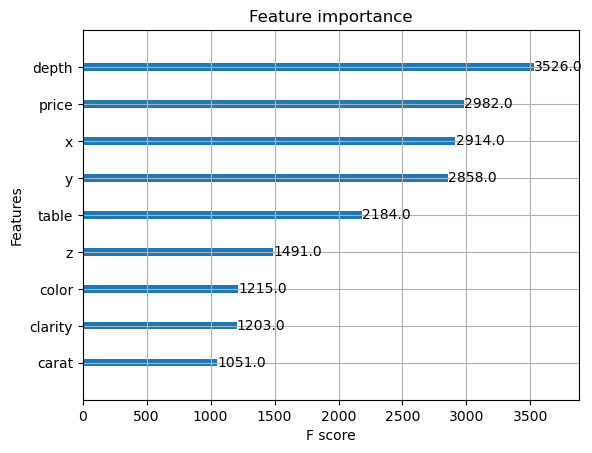

In [29]:
xgboost.plot_importance(
    xgb
    )

In [ ]:
# 트리모델 자체가 다중공선성 영향을 크게 받는 모델이 아니고 상관관계가 심한 변수들을 제외했을 때 결과 값의 차이가 크게 나므로 안빼는게 낫다.


In [30]:
from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import uniform


xgb = xgboost.XGBClassifier()
distributions = {
    'n_estimators': (range(100,201)),
    'learning_rate': (np.arange(0.1, 5, 0.1))
    }
grid_search = RandomizedSearchCV(xgb, distributions, random_state=0)
grid_search.fit(train.drop(columns=['cut']), train['cut'], eval_set= [(valid.drop(columns=['cut']), valid['cut'])])




[0]	validation_0-mlogloss:1.13106
[1]	validation_0-mlogloss:20.77897
[2]	validation_0-mlogloss:10.53533
[3]	validation_0-mlogloss:22.57869
[4]	validation_0-mlogloss:22.16013
[5]	validation_0-mlogloss:22.29255
[6]	validation_0-mlogloss:24.02192
[7]	validation_0-mlogloss:21.39924
[8]	validation_0-mlogloss:21.39924
[9]	validation_0-mlogloss:21.39924
[10]	validation_0-mlogloss:21.39924
[11]	validation_0-mlogloss:21.39924
[12]	validation_0-mlogloss:21.39924
[13]	validation_0-mlogloss:21.39924
[14]	validation_0-mlogloss:21.39924
[15]	validation_0-mlogloss:21.39924
[16]	validation_0-mlogloss:21.39924
[17]	validation_0-mlogloss:21.39924
[18]	validation_0-mlogloss:21.39924
[19]	validation_0-mlogloss:21.39924
[20]	validation_0-mlogloss:21.39924
[21]	validation_0-mlogloss:21.39924
[22]	validation_0-mlogloss:21.39924
[23]	validation_0-mlogloss:21.39924
[24]	validation_0-mlogloss:21.39924
[25]	validation_0-mlogloss:21.39924
[26]	validation_0-mlogloss:21.39924
[27]	validation_0-mlogloss:21.39924
[28

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                                        'n_estimators': range(100, 201)},
                   random_state=0)

In [31]:
grid_search.score(test.drop(columns=['cut']), test['cut'])

0.7894785760758435

In [48]:
grid_search.cv_results_.get('params')[grid_search.cv_results_.get('rank_test_score').argmin()]

{'n_estimators': 199, 'learning_rate': 0.7000000000000001}

In [50]:
grid_search.best_params_

{'n_estimators': 199, 'learning_rate': 0.7000000000000001}

In [49]:
xgb = xgboost.XGBClassifier(n_estimators = 199,
        learning_rate = 0.7,)
xgb.fit(train.drop(columns=['cut']), train['cut'],
        eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
        
        verbose = 0 # defalut는 1, 1이면 학습과정이 보이고 0이면 안보임
        )

xgb.score(test.drop(columns=['cut']), test['cut'])

0.7894785760758435

In [52]:
best_param = grid_search.best_params_
best_param

{'n_estimators': 199, 'learning_rate': 0.7000000000000001}

In [53]:
xgb = xgboost.XGBClassifier(
    best_param.get('n_estimators'),
    best_param.get('learning_rate')
)

xgb.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
    verbose = 0
    
)

xgb.score(test.drop(columns=['cut']), test['cut'])

c:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


0.8004461381169253

In [56]:
diamonds = sns.load_dataset('diamonds')
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


## Lightgbm

Paper: [Click](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) <br>
Documentation: https://lightgbm.readthedocs.io/en/stable/ <br>



In [59]:
diamonds = sns.load_dataset('diamonds')
diamonds

# null값 삭제, 중복값 삭제, 인덱스 초기화
diamonds = diamonds.dropna().drop_duplicates().reset_index(drop=True)

# 카테고리 확인

# 데이터 타입 확인
diamonds

train, test = train_test_split(diamonds, test_size= 0.2, random_state=0)
train, valid = train_test_split(train, test_size= len(test)/len(train), random_state=0)

lgbm = lightgbm.LGBMClassifier(verbose = 0)
lgbm.fit(train.drop(columns=['cut']), train['cut'],
        eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
        
        )

lgbm.score(test.drop(columns=['cut']), test['cut'])



0.8007249744400037

In [ ]:
lgbm = lightgbm.LGBMClassifier(verbose = 0)
distributions = {
    'n_estimators': (range(100,201)),
    'learning_rate': (np.arange(0.1, 5, 0.1))
    }
random_search = RandomizedSearchCV(lgbm, distributions, random_state=0)
random_search.fit(train.drop(columns=['cut']), train['cut'], eval_set= [(valid.drop(columns=['cut']), valid['cut'])])

In [64]:
import numpy as np
import lightgbm
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def lgbm_cv(
  max_depth,
  learning_rate,
  n_estimators,
  subsample,
  colsample_bytree,
):
    model = lightgbm.LGBMClassifier( # 모델은 실수형태로 반환해줘서 정수형 파라미터를 받아야 하는 애들은 정수로 바꿔줘야 한다.
        max_depth = int(max_depth),
        learning_rate = learning_rate,
        n_estimators = int(n_estimators),
        subsample = subsample,
        colsample_bytree = colsample_bytree,
    )
    
    model.fit(
        train.drop(columns=['cut']), train['cut'],
        eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
    )

    accuracy = model.score(
        test.drop(columns=['cut']), test['cut'],
    )

    return accuracy

pbounds = {
    'max_depth': (3, 10), # 일반적으로 깊이는 10을 넘지 않는 것을 권장
    'learning_rate': (0.0001, 0.5),
    'n_estimators' : (50, 500),
    'subsample' : (0.5, 1),
    'colsample_bytree' : (0.4, 1),
}

bayesian_optimization = BayesianOptimization(
    f = lgbm_cv,
    pbounds= pbounds,
    verbose= 2, # 2는 출력, 1은 최댓값일 때 출력, 0은 출력안함
    random_state= 0,
)

bayesian_optimization.maximize(
    init_points=10,
    
)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [68]:
best_params = bayesian_optimization.max.get('params')
best_params.update({
    'max_depth' : int(best_params.get('max_depth')),
    'n_estimators' : int(best_params.get('n_estimators'))
    }
)

print(best_params)

{'colsample_bytree': 0.9864861722859641, 'learning_rate': 0.10630079898847027, 'max_depth': 9, 'n_estimators': 199, 'subsample': 0.6617516390737965}


In [73]:
lgbm = lightgbm.LGBMClassifier(
    **best_params, # 언팩킹
    verbose = 0,
    random_state= 0
)

lgbm.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
)

lgbm.score(test.drop(columns=['cut']), test['cut'])

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.804071010316944

In [ ]:
# grid_search 는 모델의 파라미터가 어느 부근 에서 변동없이 높은 포인트가 나오나 그걸 알기 위해서 씀
# 

In [83]:
label_encoders = {}
for column in ('cut', 'color', 'clarity'):
    label_encoder = LabelEncoder()
    diamonds.loc[:, column] = label_encoder.fit_transform(diamonds[column])

    label_encoders.update({column: label_encoder})

train, test = train_test_split(diamonds, test_size= 0.2, random_state=0)
train, valid = train_test_split(train, test_size= len(test)/len(train), random_state=0)

def xgbm_cv(
  max_depth,
  learning_rate,
  n_estimators,
  max_leaves,
):
    model = xgboost.XGBClassifier( # 모델은 실수형태로 반환해줘서 정수형 파라미터를 받아야 하는 애들은 정수로 바꿔줘야 한다.
        max_depth = int(max_depth),
        learning_rate = learning_rate,
        n_estimators = int(n_estimators),
        max_leaves = int(max_leaves),

    )
    
    label_encoders = {}
    for column in ('cut', 'color', 'clarity'):
        label_encoder = LabelEncoder()
        diamonds.loc[:, column] = label_encoder.fit_transform(diamonds[column])

        label_encoders.update({column: label_encoder})

    train, test = train_test_split(diamonds, test_size= 0.2, random_state=0)
    train, valid = train_test_split(train, test_size= len(test)/len(train), random_state=0)


    model.fit(
        train.drop(columns=['cut']), train['cut'],
        eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
        verbose= 0, 
    )

    accuracy = model.score(
        test.drop(columns=['cut']), test['cut'],
    )

    return accuracy

pbounds = {
    'max_depth': (3, 10), # 일반적으로 깊이는 10을 넘지 않는 것을 권장
    'learning_rate': (0.0001, 0.5),
    'n_estimators' : (50, 500),
    'max_leaves' : (10, 100),
}

bayesian_optimization = BayesianOptimization(
    f = xgbm_cv,
    pbounds= pbounds,
    # 2는 출력, 1은 최댓값일 때 출력, 0은 출력안함
    random_state= 0,
)

bayesian_optimization.maximize(
    init_points=10,
    
)

|   iter    |  target   | learni... | max_depth | max_le... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7967    | 0.2745    | 8.006     | 64.25     | 295.2     |
| 2         | 0.7976    | 0.2119    | 7.521     | 49.38     | 451.3     |
| 3         | 0.7991    | 0.4818    | 5.684     | 81.26     | 288.0     |
| 4         | 0.7908    | 0.2841    | 9.479     | 16.39     | 89.21     |
| 5         | 0.7593    | 0.01021   | 8.828     | 80.03     | 441.5     |
| 6         | 0.7928    | 0.4893    | 8.594     | 51.53     | 401.2     |
| 7         | 0.7941    | 0.05923   | 7.479     | 22.9      | 475.1     |
| 8         | 0.8008    | 0.261     | 5.903     | 33.81     | 398.4     |
| 9         | 0.8019    | 0.2281    | 6.979     | 11.69     | 327.9     |
| 10        | 0.7993    | 0.3061    | 7.319     | 94.94     | 356.8     |
| 11        | 0.7727    | 0.0389    | 7.503     | 27.76     | 317.3     |
| 12        | 0.7995    | 0.2067    | 

In [84]:
best_params = bayesian_optimization.max.get('params')
best_params.update({
    'max_depth' : int(best_params.get('max_depth')),
    'n_estimators' : int(best_params.get('n_estimators')),
    'max_leaves' : int(best_params.get('max_leaves'))
    }
)

print(best_params)

{'learning_rate': 0.22812955107505262, 'max_depth': 6, 'max_leaves': 11, 'n_estimators': 327}


In [85]:
xgb = xgboost.XGBClassifier(
    **best_params, # 언팩킹
    random_state= 0
)

xgb.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
)

xgb.score(test.drop(columns=['cut']), test['cut'])

[0]	validation_0-mlogloss:1.34934
[1]	validation_0-mlogloss:1.19015
[2]	validation_0-mlogloss:1.07989
[3]	validation_0-mlogloss:0.99987
[4]	validation_0-mlogloss:0.93891
[5]	validation_0-mlogloss:0.89280
[6]	validation_0-mlogloss:0.85584
[7]	validation_0-mlogloss:0.82679
[8]	validation_0-mlogloss:0.80388
[9]	validation_0-mlogloss:0.78509
[10]	validation_0-mlogloss:0.76939
[11]	validation_0-mlogloss:0.75676
[12]	validation_0-mlogloss:0.74530
[13]	validation_0-mlogloss:0.73473
[14]	validation_0-mlogloss:0.72640
[15]	validation_0-mlogloss:0.71901
[16]	validation_0-mlogloss:0.71307
[17]	validation_0-mlogloss:0.70756
[18]	validation_0-mlogloss:0.70272
[19]	validation_0-mlogloss:0.69780
[20]	validation_0-mlogloss:0.69390
[21]	validation_0-mlogloss:0.69027
[22]	validation_0-mlogloss:0.68774
[23]	validation_0-mlogloss:0.68418
[24]	validation_0-mlogloss:0.68195
[25]	validation_0-mlogloss:0.67832
[26]	validation_0-mlogloss:0.67626
[27]	validation_0-mlogloss:0.67400
[28]	validation_0-mlogloss:0.6

0.8019332651733433

### 핵심 로직

<font style="font-size:20px"> Exclusive Feature Bundling (EFB) </font> <p>
- feature 수를 다운 샘플링해 학습 속도를 증가시키는 방법
    - 일반적으로 고차원 데이터로 작업할 때, 상호 배반적인 특성들을 결합 
    - 상호배반적: One-hot encoding에서 0이 아닌 값을 동시에 갖는 경우가 희박한 것

<br>

<font style="font-size:20px"> Gradient-based One-Sided Sampling (leaf-wise)</font> <p>
- 경사를 기반으로 인스턴스를 다운 샘플링하는 방법
- 경사가 작은 인스턴스는 잘 훈련되어 오류가 작고, 경사가 큰 인스턴스는 잘 훈련되지 않아 오류가 크다는 점을 활용
- 손실 함수에 가장 많이 기여하는 인스턴스를 샘플링하는 동시에 가장 기여하지 않는 인스턴스는 폐기

1. 경사의 절댓값을 기준으로 인스턴스를 내림차순 정렬
2. 상위 a%의 인스턴스 선택 (제대로 훈련되지 않은 데이터)
3. 나머지 데이터인 b%개의 인스턴스 샘플링 (충분히 훈련된 데이터의 기여도를 감소)
4. b를 제외한 a 샘플 만으로도 기존의 분포를 유지하기 위해 덜 훈련된 샘플들을 (1-a)/b 만큼 강조 


sparse => 원 핫 처리를 했을 때 1으로 처리한 것이 0 대비 차원이 적다.


### 장단점

<font style="font-size:20px"> 장점 </font>
- 빠른 속도
- 메모리 사용이 상대적으로 적음
- categorical feature의 자동 변환
- GPU 지원

<br>

<font style="font-size:20px"> 단점 </font>
- 과적합 문제 (10000 row 미만)
- 하이퍼파라미터 튜닝에 민감

### 사용 방법

> ```python
> import lightgbm as lgbm
> 
> lgbm_model = lgbm.LGBMClassifier(
>   n_estimators=100,
> )
> lgbm_model = lgbm.LGBMRegressor(
>   n_estimators=100,
> )
> 
> lgbm_model.fit(X, y, eval_set=[(x_val, y_val)])   # train
> lgbm_model.predict(X)                             # predict
> lgbm.plot_importance(lgbm_model)                  # feature importance
> ```

<br>

주요 파라미터
- learning_rate: 학습 시 얼마 만큼의 보폭으로 이동할 것인가 설정 (default: 0.1)
- n_estimators: weak learner의 개수 (default: 100)
- class_weight: 분류 문제의 경우 클래스 unblance가 심할 경우 사용
- max_depth: 최대 깊이 (default: $\infty$)
- num_leaves: weak learner의 최대 leaf 수 (default: 31)
- min_child_samples: leaf를 만들기 위한 최소 샘플 수 (default: 20)

local minia, global minia


In [54]:
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53789,0.72,2,0,2,60.8,57.0,2757,5.75,5.76,3.50
53790,0.72,1,0,2,63.1,55.0,2757,5.69,5.75,3.61
53791,0.70,4,0,2,62.8,60.0,2757,5.66,5.68,3.56
53792,0.86,3,4,3,61.0,58.0,2757,6.15,6.12,3.74


## CatBoost

Paper: [Click](https://proceedings.neurips.cc/paper_files/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf) <br>
Documentation: https://catboost.ai/en/docs/ <br>




### 핵심 로직

<font style="font-size:20px"> Ordered Boosting </font> <p>
- 전체 잔차를 사용하는 것이 아니라 일부를 가지고 잔차를 적합시키는 방식으로 동작

<br>

<font style="font-size:20px"> Random Permutation </font> <p>
- 데이터의 순서를 섞어 트리를 다각적으로 만듦

<br>

<font style="font-size:20px"> Ordered Target </font> <p>
- Target Encoding, Mean Encoding, Response Encoding 등
- 범주형 변수를 인코딩 시키는 방법으로 label의 평균을 사용
     - 단순 평균은 data leakage 문제를 발생시켜 미래 값을 보지 않도록 인코딩

<br>

<font style="font-size:20px"> Categorical Feature Combination </font> <p>
- information gain이 동일한 feature를 하나의 feature로 결합

<br>

<font style="font-size:20px"> One-hot Encoding </font> <p>
- Low Cardinality를 가지는 변수를 one-hot으로 변환

Cardinality => 컬럼들이 주는 정보
Low Cardinality => 중복정도가 낮은거

### 장단점

<font style="font-size:20px"> 장점 </font>
- 하이퍼파라미터 튜닝에 민감하지 않음 (로직으로 최적화)
- 범주형 변수에 대해 높은 성능

<br>

<font style="font-size:20px"> 단점 </font>
- 수치형 자료가 많은 경우 학습 속도가 느림

### 사용 방법

> ```python
> import catboost
> 
> catboost_model = catboost.CatBoostClassifier(
>   n_estimators=100,
> )
> catboost_model = catboost.CatBoostRegressor(
>   n_estimators=100,
> )
> 
> catboost_model.fit(X, y, eval_set=[(x_val, y_val)])    # train
> catboost_model.predict(X)                              # predict
> catboost.get_feature_importance()
> ```

<br>

주요 파라미터
- learning_rate: 학습 시 얼마 만큼의 보폭으로 이동할 것인가 설정
- n_estimators: weak learner의 개수
- class_weight: 분류 문제의 경우 클래스 unblance가 심할 경우 사용
- max_depth: 최대 깊이
- num_leaves: weak learner의 최대 leaf 수
- min_data_in_leaf: leaf를 만들기 위한 최소 샘플 수
- subsample: 전체 샘플에서 데이터 사용 비중
- colsample_bylevel: 전체 column에서 사용할 column 비율

In [92]:
# data leakage 데이터 유출 되게 중요한 문제



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [114]:

diamonds = sns.load_dataset('diamonds')
diamonds

# null값 삭제, 중복값 삭제, 인덱스 초기화
diamonds = diamonds.dropna().drop_duplicates().reset_index(drop=True)

diamonds['cut'] = diamonds['cut'].astype(str)
diamonds['color'] = diamonds['color'].astype(str)
diamonds['clarity'] = diamonds['clarity'].astype(str)


train, test = train_test_split(diamonds, test_size= 0.2, random_state=0)
train, valid = train_test_split(train, test_size= len(test)/len(train), random_state=0)

cat = catboost.CatBoostClassifier()

cat.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set= [(valid.drop(columns=['cut']), valid['cut'])],
    cat_features= np.where(train.drop(columns=['cut']).dtypes == object)[0]
)

cat.score(test.drop(columns=['cut']), test['cut'])

Learning rate set to 0.115746
0:	learn: 1.4120359	test: 1.4094086	best: 1.4094086 (0)	total: 209ms	remaining: 3m 28s
1:	learn: 1.2864654	test: 1.2826718	best: 1.2826718 (1)	total: 267ms	remaining: 2m 13s
2:	learn: 1.1923192	test: 1.1874639	best: 1.1874639 (2)	total: 330ms	remaining: 1m 49s
3:	learn: 1.1197474	test: 1.1143121	best: 1.1143121 (3)	total: 382ms	remaining: 1m 35s
4:	learn: 1.0625812	test: 1.0566500	best: 1.0566500 (4)	total: 436ms	remaining: 1m 26s
5:	learn: 1.0198772	test: 1.0133767	best: 1.0133767 (5)	total: 489ms	remaining: 1m 21s
6:	learn: 0.9804410	test: 0.9735796	best: 0.9735796 (6)	total: 545ms	remaining: 1m 17s
7:	learn: 0.9488935	test: 0.9416767	best: 0.9416767 (7)	total: 599ms	remaining: 1m 14s
8:	learn: 0.9197444	test: 0.9126282	best: 0.9126282 (8)	total: 654ms	remaining: 1m 12s
9:	learn: 0.8955288	test: 0.8882912	best: 0.8882912 (9)	total: 711ms	remaining: 1m 10s
10:	learn: 0.8748272	test: 0.8673708	best: 0.8673708 (10)	total: 763ms	remaining: 1m 8s
11:	learn: 0

0.7971930476810113

In [137]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/gender_submission.csv')

train = train.dropna(subset=train.columns.difference(['Age', 'Cabin', 'Embarked']))
train = train.astype(dict(zip(np.extract(train.dtypes == object, train.columns), ['category']*5)))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(5), float64(2), int64(5)
memory usage: 122.0 KB


In [141]:
train, valid = train_test_split(train, test_size=0.3)
lgbm = lightgbm.LGBMClassifier()
lgbm.fit(train.drop(columns=['Survived', 'PassengerId', 'Age', 'Cabin', 'Embarked']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived', 'PassengerId', 'Age', 'Cabin', 'Embarked']), valid['Survived'])],
        
        )



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier()

In [142]:
test = test.astype(dict(zip(np.extract(test.dtypes == object, test.columns), ['category']*5)))

In [143]:
submission.Survived = lgbm.predict(test.drop(columns=['PassengerId', 'Age', 'Cabin', 'Embarked']))

In [145]:
submission.to_csv('./data/submission.csv', index=False)

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436 entries, 826 to 582
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  436 non-null    int64   
 1   Survived     436 non-null    int64   
 2   Pclass       436 non-null    int64   
 3   Name         436 non-null    category
 4   Sex          436 non-null    category
 5   Age          353 non-null    float64 
 6   SibSp        436 non-null    int64   
 7   Parch        436 non-null    int64   
 8   Ticket       436 non-null    category
 9   Fare         436 non-null    float64 
 10  Cabin        92 non-null     category
 11  Embarked     436 non-null    category
dtypes: category(5), float64(2), int64(5)
memory usage: 96.9 KB


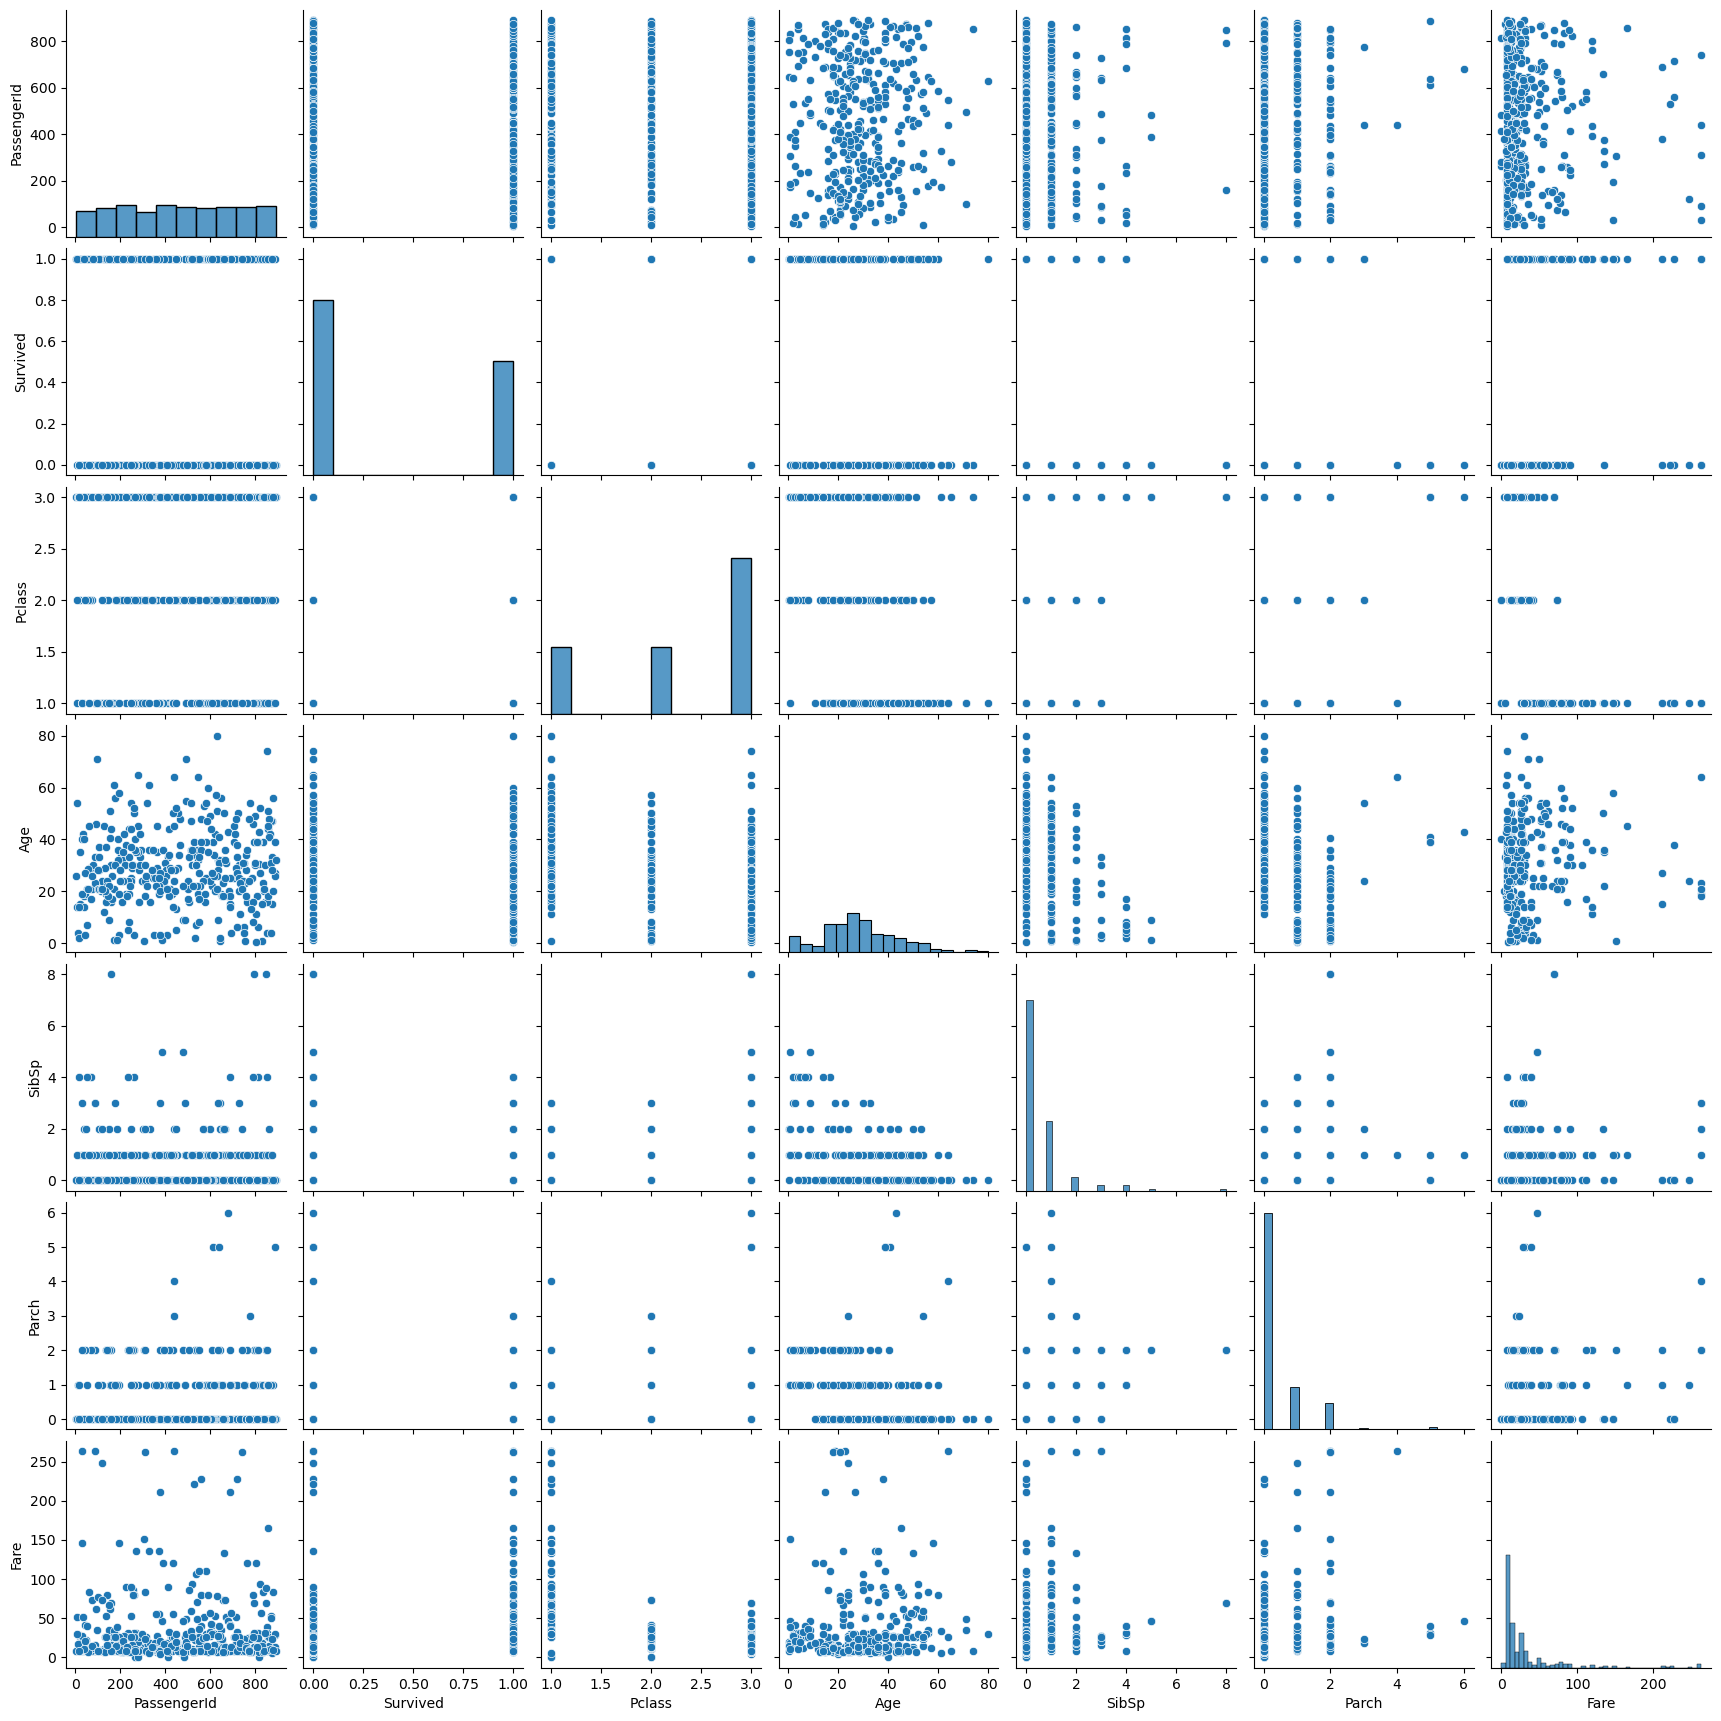

In [165]:
sns.pairplot(
    train.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])
)

In [166]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/gender_submission.csv')

# train = train.dropna(subset=train.columns.difference(['Age', 'Cabin', 'Embarked']))
train = train.astype(dict(zip(np.extract(train.dtypes == object, train.columns), ['category']*5)))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(5), float64(2), int64(5)
memory usage: 122.0 KB


In [167]:
train, valid = train_test_split(train, test_size=0.3)
lgbm = lightgbm.LGBMClassifier()
lgbm.fit(train.drop(columns=['Survived']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
        
        )



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier()

In [168]:
test = test.astype(dict(zip(np.extract(test.dtypes == object, test.columns), ['category']*5)))

In [169]:
submission.Survived = lgbm.predict(test)

In [170]:
submission.to_csv('./data/submission.csv', index=False)

In [182]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/gender_submission.csv')

# train = train.dropna(subset=train.columns.difference(['Age', 'Cabin', 'Embarked']))
train.Age = train.Age.fillna(train.Age.mean())
train.dropna()
#train = train.astype(dict(zip(np.extract(train.dtypes == object, train.columns), ['category']*5)))
train.info()

cat = catboost.CatBoostClassifier()

cat.fit(
    train.drop(columns=['Survived']), train['Survived'],
    eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
    cat_features= np.where(train.drop(columns=['Survived']).dtypes == object)[0]
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=9]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [221]:
train = pd.read_csv('./data/train.csv') #Pclass SibSp Parch    Parch(0) Fare   Cabin Embarked

train = train.filter(items=['Pclass', 'SibSp','Parch','Fare','Cabin', 'Embarked', 'Age', 'Sex','Survived'])
train.isna().sum()

Pclass        0
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
Age         177
Sex           0
Survived      0
dtype: int64

In [222]:
train.Cabin = train.Cabin.fillna(0)

In [227]:
train.Age = train.Age.fillna(train.Age.mean())

In [228]:
train

,Pclass,SibSp,Parch,Fare,Cabin,Embarked,Age,Sex,Survived
0,3,1,0,7.2500,0,S,22.000000,male,0
1,1,1,0,71.2833,C85,C,38.000000,female,1
2,3,0,0,7.9250,0,S,26.000000,female,1
3,1,1,0,53.1000,C123,S,35.000000,female,1
4,3,0,0,8.0500,0,S,35.000000,male,0
...,...,...,...,...,...,...,...,...,...
886,2,0,0,13.0000,0,S,27.000000,male,0
887,1,0,0,30.0000,B42,S,19.000000,female,1
888,3,1,2,23.4500,0,S,29.699118,female,0
889,1,0,0,30.0000,C148,C,26.000000,male,1


<Axes: xlabel='Age', ylabel='count'>

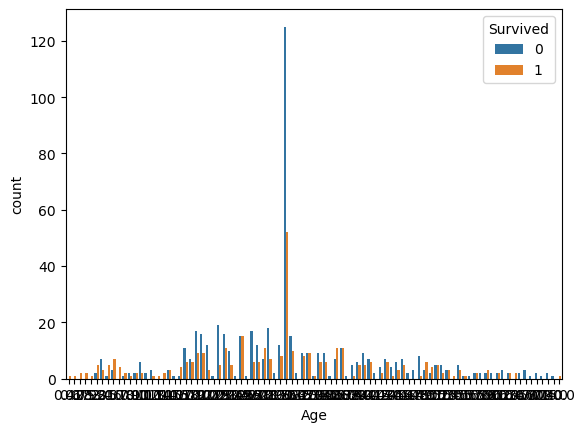

In [229]:
sns.countplot(
    train,
    x = 'Age',
    hue = 'Survived'
)

In [231]:


train = train.astype(dict(zip(np.extract(train.dtypes == object, train.columns), ['category']*3)))
train.info()
train, valid = train_test_split(train, test_size=0.3)

lgbm = lightgbm.LGBMClassifier()
lgbm.fit(train.drop(columns=['Survived']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
        
        )



<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 275 to 544
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    623 non-null    int64   
 1   SibSp     623 non-null    int64   
 2   Parch     623 non-null    int64   
 3   Fare      623 non-null    float64 
 4   Cabin     623 non-null    category
 5   Embarked  621 non-null    category
 6   Age       623 non-null    float64 
 7   Sex       623 non-null    category
 8   Survived  623 non-null    int64   
dtypes: category(3), float64(2), int64(4)
memory usage: 41.2 KB
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

LGBMClassifier()

In [233]:

test = test.filter(items=['Pclass', 'SibSp','Parch','Fare','Cabin', 'Embarked', 'Age', 'Sex','Survived'])
test = test.astype(dict(zip(np.extract(test.dtypes == object, test.columns), ['category']*3)))
submission.Survived = lgbm.predict(test)
submission.to_csv('./data/submission.csv', index=False)

In [236]:
train = pd.read_csv('./data/train.csv')
train.Cabin = train.Cabin.fillna('N')
train.Cabin = train.Cabin.apply(lambda x :x[:1])

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,N,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,N,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C


In [240]:

train = train.filter(items=['Pclass', 'SibSp','Parch','Fare','Cabin', 'Embarked', 'Sex','Survived'])
train.isna().sum()

train = train.astype(dict(zip(np.extract(train.dtypes == object, train.columns), ['category']*3)))
train.info()
train, valid = train_test_split(train, test_size=0.3)

lgbm = lightgbm.LGBMClassifier()
lgbm.fit(train.drop(columns=['Survived']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
        
        )



<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 695 to 186
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    623 non-null    int64   
 1   SibSp     623 non-null    int64   
 2   Parch     623 non-null    int64   
 3   Fare      623 non-null    float64 
 4   Cabin     623 non-null    category
 5   Embarked  622 non-null    category
 6   Sex       623 non-null    category
 7   Survived  623 non-null    int64   
dtypes: category(3), float64(1), int64(4)
memory usage: 31.6 KB
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier()

In [241]:

test = test.filter(items=['Pclass', 'SibSp','Parch','Fare','Cabin', 'Embarked','Sex'])
test = test.astype(dict(zip(np.extract(test.dtypes == object, test.columns), ['category']*3)))
submission.Survived = lgbm.predict(test)
submission.to_csv('./data/submission.csv', index=False)

In [244]:
test

,Pclass,SibSp,Parch,Fare,Cabin,Embarked,Sex
0,3,0,0,7.8292,NaN,Q,male
1,3,1,0,7.0000,NaN,S,female
2,2,0,0,9.6875,NaN,Q,male
3,3,0,0,8.6625,NaN,S,male
4,3,1,1,12.2875,NaN,S,female
...,...,...,...,...,...,...,...
413,3,0,0,8.0500,NaN,S,male
414,1,0,0,108.9000,C105,C,female
415,3,0,0,7.2500,NaN,S,male
416,3,0,0,8.0500,NaN,S,male


In [267]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/gender_submission.csv')

train.Cabin = train.Cabin.fillna('N')
train.Cabin = train.Cabin.apply(lambda x :x[:1])

In [250]:
train.Sex

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [268]:
train['adult_male'] = np.where((train['Age'] > 18) & (train['Sex'] == "male"), 1, 0)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,adult_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,N,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,N,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,1


In [269]:
train = train.astype(dict(zip(np.extract(train.dtypes == object, train.columns), ['category']*5)))

In [270]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    category
 11  Embarked     889 non-null    category
 12  adult_male   891 non-null    int32   
dtypes: category(5), float64(2), int32(1), int64(5)
memory usage: 119.8 KB


In [271]:
train, valid = train_test_split(train, test_size=0.3)

lgbm = lightgbm.LGBMClassifier()
lgbm.fit(train.drop(columns=['Survived']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
        
        )

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier()

In [274]:
test['adult_male'] = np.where((test['Age'] > 18) & (test['Sex'] == "male"), 1, 0)
test = test.astype(dict(zip(np.extract(test.dtypes == object, test.columns), ['category']*5)))
submission.Survived = lgbm.predict(test)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [284]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/gender_submission.csv')

In [276]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [285]:
train.Cabin = train.Cabin.fillna('N')
train.Cabin = train.Cabin.apply(lambda x :x[:1])
train['adult_male'] = np.where((train['Age'] > 18) & (train['Sex'] == "male"), 1, 0)



In [ ]:


def xgbm_cv(
  max_depth,
  learning_rate,
  n_estimators,
  max_leaves,
):
    model = xgboost.XGBClassifier( # 모델은 실수형태로 반환해줘서 정수형 파라미터를 받아야 하는 애들은 정수로 바꿔줘야 한다.
        max_depth = int(max_depth),
        learning_rate = learning_rate,
        n_estimators = int(n_estimators),
        max_leaves = int(max_leaves),

    )
    
    label_encoders = {}
    for column in ('Sex', 'Ticket', 'Cabin', 'Embarked'):
        label_encoder = LabelEncoder()
        train.loc[:, column] = label_encoder.fit_transform(train[column])

        label_encoders.update({column: label_encoder})

    train, valid = train_test_split(train, test_size=0.3)


    model.fit(
        train.drop(columns=['Survived']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
        verbose= 0, 
    )

    accuracy = model.score(
        test.drop(columns=['cut']), test['cut'],
    )

    return accuracy

pbounds = {
    'max_depth': (3, 10), # 일반적으로 깊이는 10을 넘지 않는 것을 권장
    'learning_rate': (0.0001, 0.5),
    'n_estimators' : (50, 500),
    'max_leaves' : (10, 100),
}

bayesian_optimization = BayesianOptimization(
    f = xgbm_cv,
    pbounds= pbounds,
    # 2는 출력, 1은 최댓값일 때 출력, 0은 출력안함
    random_state= 0,
)

bayesian_optimization.maximize(
    init_points=10,
    
)

In [286]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     889 non-null    object 
 12  adult_male   891 non-null    int32  
dtypes: float64(2), int32(1), int64(5), object(5)
memory usage: 87.1+ KB


In [282]:
label_encoders = {}
for column in ('Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'):
    label_encoder = LabelEncoder()
    train.loc[:, column] = label_encoder.fit_transform(train[column])

    label_encoders.update({column: label_encoder})


In [283]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 432 to 527
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  213 non-null    int64  
 1   Survived     213 non-null    int64  
 2   Pclass       213 non-null    int64  
 3   Name         213 non-null    object 
 4   Sex          213 non-null    object 
 5   Age          162 non-null    float64
 6   SibSp        213 non-null    int64  
 7   Parch        213 non-null    int64  
 8   Ticket       213 non-null    object 
 9   Fare         213 non-null    float64
 10  Cabin        213 non-null    object 
 11  Embarked     213 non-null    object 
 12  adult_male   213 non-null    int32  
dtypes: float64(2), int32(1), int64(5), object(5)
memory usage: 22.5+ KB


In [281]:
label_encoders = {}

for column in ('Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'):
    label_encoder = LabelEncoder()
    train.loc[:, column] = label_encoder.fit_transform(train[column])
    label_encoders.update({column: label_encoder})

train.info()
train, valid = train_test_split(train, test_size=0.3)


xgb = xgboost.XGBClassifier()
xgb.fit(train.drop(columns=['Survived']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
        verbose = 0 # defalut는 1, 1이면 학습과정이 보이고 0이면 안보임
        )

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 416 to 265
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  305 non-null    int64  
 1   Survived     305 non-null    int64  
 2   Pclass       305 non-null    int64  
 3   Name         305 non-null    object 
 4   Sex          305 non-null    object 
 5   Age          239 non-null    float64
 6   SibSp        305 non-null    int64  
 7   Parch        305 non-null    int64  
 8   Ticket       305 non-null    object 
 9   Fare         305 non-null    float64
 10  Cabin        305 non-null    object 
 11  Embarked     305 non-null    object 
 12  adult_male   305 non-null    int32  
dtypes: float64(2), int32(1), int64(5), object(5)
memory usage: 32.2+ KB


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Name: object, Sex: object, Ticket: object, Cabin: object, Embarked: object

In [287]:
#'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'
label_encoder = LabelEncoder()
train['Name'] = label_encoder.fit_transform(train['Name'])
train['Sex'] = label_encoder.fit_transform(train['Sex'])
train['Ticket'] = label_encoder.fit_transform(train['Ticket'])
train['Cabin'] = label_encoder.fit_transform(train['Cabin'])
train['Embarked'] = label_encoder.fit_transform(train['Embarked'])



In [288]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    int32  
 4   Sex          891 non-null    int32  
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    int32  
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    int32  
 11  Embarked     891 non-null    int32  
 12  adult_male   891 non-null    int32  
dtypes: float64(2), int32(6), int64(5)
memory usage: 69.7 KB


In [289]:
train, valid = train_test_split(train, test_size=0.3)


xgb = xgboost.XGBClassifier()
xgb.fit(train.drop(columns=['Survived']), train['Survived'],
        eval_set= [(valid.drop(columns=['Survived']), valid['Survived'])],
        verbose = 0 # defalut는 1, 1이면 학습과정이 보이고 0이면 안보임
        )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [295]:
test['adult_male'] = np.where((test['Age'] > 18) & (test['Sex'] == "male"), 1, 0)
test = test.astype(dict(zip(np.extract(test.dtypes == object, test.columns), ['category']*5)))

test['Name'] = label_encoder.fit_transform(test['Name'])
test['Sex'] = label_encoder.fit_transform(test['Sex'])
test['Ticket'] = label_encoder.fit_transform(test['Ticket'])
test['Cabin'] = label_encoder.fit_transform(test['Cabin'])
test['Embarked'] = label_encoder.fit_transform(test['Embarked'])
test.info()
print(train.info())

submission.Survived = lgbm.predict(test)
submission

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    int64  
 3   Sex          418 non-null    int64  
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    int64  
 8   Fare         417 non-null    float64
 9   Cabin        418 non-null    int64  
 10  Embarked     418 non-null    int64  
 11  adult_male   418 non-null    int32  
dtypes: float64(2), int32(1), int64(9)
memory usage: 37.7 KB
<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 793 to 648
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  623 non-null    int64  
 1   Survived     

ValueError: train and valid dataset categorical_feature do not match.